In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import auc, roc_curve, confusion_matrix
import torch
import seaborn as sns
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
pd_data = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
pd_test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [3]:
pd_data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [4]:
pd_data.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


# Pipelines preprocessing

Global pipelines

In [5]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, *features:str):
        self.features = features
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self    
    def transform(self, X):
        X.drop(labels=[*self.features], inplace=True, axis=1, errors='ignore')
        print(f'Dropped features')
        return X

In [6]:
class FeatureDropperNa(BaseEstimator, TransformerMixin):
    def __init__(self, *features:str):
        self.features = features
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.features:
            X.dropna(subset=[*self.features], inplace=True)
        return X

In [7]:
class FeatureChanger(BaseEstimator, TransformerMixin):
    def __init__(self, dict_replace_value:dict, feature:str):
        self.dict_replace_value =  dict_replace_value
        self.feature = feature
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self   
    def transform(self, X):
        X[self.feature].replace(self.dict_replace_value, inplace=True)
        print(f'Changed feature')
        return X

In [8]:
class FeatureImputer(BaseEstimator, TransformerMixin):
    def __init__(self, feature:str, value):
        self.feature = feature
        self.value = value
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        X[self.feature].fillna(value=self.value, inplace=True)
        print(f'Imputed feature')
        return X

In [9]:
class FeatureOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, feature:str):
        self.feature = feature
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self   
    def transform(self, X):
        if X[self.feature].isnull().sum() > 0:
            print('First impute NaN values (FeatureImputer)')
        elif len(X[self.feature].unique()) > 10:
            print('Too many unique values (more than 10)')
        else:
            enc = OneHotEncoder()       #sklearn.preprocessing
            matrix = enc.fit_transform(X[[self.feature]]).toarray().astype(int)
            for i in range(len(enc.categories_[0])):
                X[enc.categories_[0][i]] = matrix[:,i]
            print(f'Encoded feature')
        return X

In [10]:
class FeatureLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, feature:str):
        self.feature = feature
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if X[self.feature].isnull().sum() > 0:
            print('First impute NaN values (FeatureImputer)')
        else:
            X[self.feature] = LabelEncoder().fit_transform(X[self.feature])
        return X

In [11]:
class FeatureMinMaxNorm(BaseEstimator, TransformerMixin):
    def __init__(self, *features):
        self.features = features
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.features:
            for feature in self.features:
                X[feature] = (X[feature] - X[feature].min()) / (X[feature].max() - X[feature].min())
        return X

In [12]:
class FeaturesSum(BaseEstimator, TransformerMixin):
    def __init__(self, *features:str, **name_feature):
        self.features = features
        self.name_feature = name_feature
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if not self.name_feature:
            new_f = f'new_{self.features[0]}'
        for _, v in self.name_feature.items():
            new_f = v
            break
        X[new_f] = 0
        for feature in self.features:
            X[new_f] += X[feature]
        print(f'Sum feature')
        return X

In [13]:
def cat_features(dataframe, *labels):
    for label in labels:
        ser = dataframe[label].value_counts()
        sum_val = ser.sum()
        ser = (ser / sum_val).round(2)
        print(f'Max - {ser.max()} is {ser.idxmax()} fill NaN "{label}" that value')

In [14]:
cat_features(pd_data, 'HomePlanet', 'Destination')

Max - 0.54 is Earth fill NaN "HomePlanet" that value
Max - 0.69 is TRAPPIST-1e fill NaN "Destination" that value


In [15]:
pd_data['Age'].mean().round(0)

29.0

**Set_1**
* PassengerId drop - alternative 0 or 1 if single or not
* HomePlanet fill nan (nan - Earth), onehotencode
* CryoSleep true/false to 1,0 (nan - 0)
* Cabin (deck/num/side) paste deck, side (nan deck - max_value, nan side - max_value and use onehotencoder
* Destination fill nan (nan - TRAPPIST-1e), onehotencode
* Age fill nan (nan - mean value 29) normalize
* VIP true/false to 1,0 (nan - 0)
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - (nan - 0) sum , divide to category and onehotencode normalize
* Name drop 
* Transported - true/false to 1,0 **TARGET**

**Set_2**

* PassengerId drop - alternative 0 or 1 if single or not
* HomePlanet fill nan (nan - Earth), labelencoder normalize
* CryoSleep true/false to 1,0 (nan - 0)
* Cabin (deck/num/side) paste deck, side (nan deck - max_value, nan side - max_value and use labelencoder normalize
* Destination fill nan (nan - TRAPPIST-1e), labelencoder normalize
* Age fill nan (nan - mean value - 29) normalize
* VIP true/false to 1,0 (nan - 0)
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - (nan - 0) sum , divide to category and labelencoder normalize
* Name drop 
* Transported - true/false to 1,0 **TARGET**

**Set_3**

* PassengerId drop - alternative 0 or 1 if single or not
* HomePlanet fill nan (nan - Earth), onehotencode
* CryoSleep true/false to 1,0 (nan - 0)
* Cabin (deck/num/side) paste deck, side (nan deck - max_value, nan side - max_value and use onehotencoder
* Destination fill nan (nan - TRAPPIST-1e), onehotencode
* Age fill nan (nan - mean value 29) normalize divide to category and onehotencoder (cats 0-1, 1-5, 5-10, 10-15, 15-18, 18-30, 30-45, 45-55, 55...) 
* VIP true/false to 1,0 (nan - 0)
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - (nan - 0) normalize. Sum , divide to category and onehotencode
* Name drop 
* Transported - true/false to 1,0 TARGET

# set_1

*Pipelines for set_1*

In [16]:
class FeatureCabinSep(BaseEstimator, TransformerMixin):
    def __init__(self):
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[['Cabin_d', 'Cabin_n', 'Cabin_s']] = X['Cabin'].str.split('/', expand=True)
        X.drop(labels=['Cabin_n', 'Cabin'], inplace=True, axis=1, errors='ignore')
        for feature in ['Cabin_d', 'Cabin_s']:
            na_value = X[feature].value_counts().idxmax()
            X[feature].fillna(na_value, inplace=True)
            ohe = FeatureOneHotEncoder(feature)
            ohe.transform(X)
            X.drop(labels=feature, inplace=True, axis=1, errors='ignore')
        print('Cabin feature is divided')
        return X

In [17]:
class FeaturePassengerId(BaseEstimator, TransformerMixin):
    def __init__(self):
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Group_pass'] = X['PassengerId'].str.split('_', expand=True)[0]
        X['Group_pass'] = np.where(X['Group_pass'].duplicated(keep=False), 1, 0)
        return X

In [18]:
criterion = (5000, 10000)
class FeatureLuxury(BaseEstimator, TransformerMixin):
    def __init__(self, criterion=criterion):
        self.criterion = criterion
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for feature in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
            X[feature].fillna(0, inplace=True)
        sum = FeaturesSum('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', name='Luxury')
        sum.transform(X)
        X.loc[(X['Luxury'] <= self.criterion[0]), 'Luxury_group'] = 'Low_luxury'
        X.loc[(X['Luxury'] > self.criterion[0]) & (X['Luxury'] < self.criterion[1]), 'Luxury_group'] = 'Mid_luxury'
        X.loc[(X['Luxury'] > self.criterion[1]), 'Luxury_group'] = 'High_luxury'
        ohe_lux = FeatureOneHotEncoder('Luxury_group')
        ohe_lux.transform(X)
        FeatureDropper('Luxury', 'Luxury_group').transform(X)
        return X

In [19]:
true_false = {True: 1, False: 0}
data_pipeline_set_1 =[('cabin_sep', FeatureCabinSep()),
                ('passengerId_sep', FeaturePassengerId()),
                ('luxury_feature', FeatureLuxury()),
                ('homeplanet_na', FeatureImputer('HomePlanet', 'Earth')), 
                ('CryoSleep_na', FeatureImputer('CryoSleep', False)),
                ('Destination_na', FeatureImputer('Destination', 'TRAPPIST-1e')),
                ('Age_na', FeatureImputer('Age', 29)),
                ('VIP_na', FeatureImputer('VIP', False)),     
                ('homeplanet_ohe', FeatureOneHotEncoder('HomePlanet')),
                ('Destination_ohe', FeatureOneHotEncoder('Destination')),
                ('VIP_ch', FeatureChanger(true_false, 'VIP')),
                ('CryoSleep_ch', FeatureChanger(true_false, 'CryoSleep')),
                ('drop_feature', FeatureDropper('Name', 'PassengerId', 'HomePlanet', 'Destination')),
                ('Age_normalization', FeatureMinMaxNorm('Age')),
                ('Lux_normalization', FeatureMinMaxNorm('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck')), 
               ]
data_pipeline_train_set_1 = data_pipeline_set_1.copy()
data_pipeline_train_set_1.append(('Transported_ch', FeatureChanger(true_false, 'Transported')))

FeatureCabinSep initiate
FeaturePassengerId initiate
FeatureLuxury initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureOneHotEncoder initiate
FeatureOneHotEncoder initiate
FeatureChanger initiate
FeatureChanger initiate
FeatureDropper initiate
FeatureMinMaxNorm initiate
FeatureMinMaxNorm initiate
FeatureChanger initiate


In [20]:
set_1 = pd_data.copy()
data_pipe_set_1 = Pipeline(data_pipeline_train_set_1)
data_pipe_set_1.transform(set_1)
set_1.head(3)

FeatureOneHotEncoder initiate
Encoded feature
FeatureOneHotEncoder initiate
Encoded feature
Cabin feature is divided
FeaturesSum initiate
Sum feature
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Encoded feature
Encoded feature
Changed feature
Changed feature
Dropped features
Changed feature


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,A,...,Group_pass,High_luxury,Low_luxury,Mid_luxury,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,0,0.493671,0,0.000000,0.000000,0.000000,0.00000,0.000000,0,0,...,0,0,1,0,0,1,0,0,0,1
1,0,0.303797,0,0.007608,0.000302,0.001064,0.02450,0.001823,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0,0.734177,1,0.003001,0.119948,0.000000,0.29967,0.002030,0,1,...,1,1,0,0,0,1,0,0,0,1


# set_2

*Pipelines for set_2*

In [21]:
class FeatureCabinSep_2(BaseEstimator, TransformerMixin):
    def __init__(self):
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[['Cabin_d', 'Cabin_n', 'Cabin_s']] = X['Cabin'].str.split('/', expand=True)
        X.drop(labels=['Cabin_n', 'Cabin'], inplace=True, axis=1, errors='ignore')
        for feature in ['Cabin_d', 'Cabin_s']:
            na_value = X[feature].value_counts().idxmax()
            X[feature].fillna(na_value, inplace=True)
            le = FeatureLabelEncoder(feature)
            le.transform(X)
        print('Cabin feature is divided')
        return X

In [22]:
criterion = (5000, 10000)
class FeatureLuxury_2(BaseEstimator, TransformerMixin):
    def __init__(self, criterion=criterion):
        self.criterion = criterion
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for feature in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
            X[feature].fillna(0, inplace=True)
        sum = FeaturesSum('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', name='Luxury')
        sum.transform(X)
        X.loc[(X['Luxury'] <= self.criterion[0]), 'Luxury_group'] = 'Low_luxury'
        X.loc[(X['Luxury'] > self.criterion[0]) & (X['Luxury'] < self.criterion[1]), 'Luxury_group'] = 'Mid_luxury'
        X.loc[(X['Luxury'] > self.criterion[1]), 'Luxury_group'] = 'High_luxury'
        le_lux = FeatureLabelEncoder('Luxury_group')
        le_lux.transform(X)
        FeatureDropper('Luxury').transform(X)
        return X

In [23]:
true_false = {True: 1, False: 0}
data_pipeline_set_2 =[('cabin_sep_2', FeatureCabinSep_2()),
                ('passengerId_sep', FeaturePassengerId()),
                ('luxury_feature_2', FeatureLuxury_2()),
                ('homeplanet_na', FeatureImputer('HomePlanet', 'Unknown_planet')), 
                ('CryoSleep_na', FeatureImputer('CryoSleep', False)),
                ('Destination_na', FeatureImputer('Destination', 'Unknown_dest')),
                ('Age_na', FeatureImputer('Age', 29)),
                ('VIP_na', FeatureImputer('VIP', False)),     
                ('homeplanet_label', FeatureLabelEncoder('HomePlanet')),
                ('Destination_label', FeatureLabelEncoder('Destination')),
                ('VIP_ch', FeatureChanger(true_false, 'VIP')),
                ('CryoSleep_ch', FeatureChanger(true_false, 'CryoSleep')),
                ('drop_feature', FeatureDropper('Name', 'PassengerId')),
                ('normalization', FeatureMinMaxNorm('Age', 'HomePlanet', 'Destination', 
                                                    'Cabin_d', 'Cabin_s')),
                ('normalization_lux', FeatureMinMaxNorm('Luxury_group', 'RoomService', 'FoodCourt', 
                                                        'ShoppingMall', 'Spa', 'VRDeck'))
               ]
data_pipeline_train_set_2 = data_pipeline_set_2.copy()
data_pipeline_train_set_2.append(('Transported_ch', FeatureChanger(true_false, 'Transported')))

FeatureCabinSep_2 initiate
FeaturePassengerId initiate
FeatureLuxury_2 initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureLabelEncoder initiate
FeatureLabelEncoder initiate
FeatureChanger initiate
FeatureChanger initiate
FeatureDropper initiate
FeatureMinMaxNorm initiate
FeatureMinMaxNorm initiate
FeatureChanger initiate


In [24]:
set_2 = pd_data.copy()
data_pipe_set_2 = Pipeline(data_pipeline_train_set_2)
data_pipe_set_2.transform(set_2)
set_2.head(3)

FeatureLabelEncoder initiate
FeatureLabelEncoder initiate
Cabin feature is divided
FeaturesSum initiate
Sum feature
FeatureLabelEncoder initiate
FeatureDropper initiate
Dropped features
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Changed feature
Changed feature
Dropped features
Changed feature


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_d,Cabin_s,Group_pass,Luxury_group
0,0.333333,0,0.666667,0.493671,0,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.142857,0.0,0,0.5
1,0.000000,0,0.666667,0.303797,0,0.007608,0.000302,0.001064,0.02450,0.001823,1,0.714286,1.0,0,0.5
2,0.333333,0,0.666667,0.734177,1,0.003001,0.119948,0.000000,0.29967,0.002030,0,0.000000,1.0,1,0.0


# set_3

* PassengerId drop - alternative 0 or 1 if single or not
* HomePlanet fill nan (nan - max_value), onehotencode
* CryoSleep true/false to 1,0 (nan - 0)
* Cabin (deck/num/side) paste deck, side (nan deck - Unknown_cab_deck, nan side - Unknown_cab_side and use onehotencoder
* Destination fill nan (nan - max_value), onehotencode
* Age fill nan (nan - mean value 29) normalize divide to category and onehotencoder (cats 0-1, 1-5, 5-10, 10-15, 15-18, 18-30, 30-45, 45-55, 55...)
* VIP true/false to 1,0 (nan - 0)
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - (nan - 0) normalize. Sum , divide to category and onehotencode
* Name drop
* Transported - true/false to 1,0 TARGET

In [25]:
criterion = ((0,1), (1,5), (5,10), (10,15), (15,20), (20,30), (30,45), (45,55), (55,150))
class FeatureCat(BaseEstimator, TransformerMixin):
    def __init__(self, feature, criterion=criterion):
        self.feature = feature
        self.criterion = criterion
        print(f'{__class__.__name__} initiate')
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for i, c in zip(range(len(self.criterion)), self.criterion):
            X.loc[(X[self.feature] >= c[0]) & (X[self.feature] < c[1]), f'{self.feature}_groups'] = f'{self.feature}_gr_{i+1}'
        print(X[f'{self.feature}_groups'].isnull().sum())
        FeatureOneHotEncoder(f'{self.feature}_groups').transform(X)
        FeatureDropper(f'{self.feature}_groups').transform(X)
        return X

In [26]:
true_false = {True: 1, False: 0}
data_pipeline_set_3 =[('cabin_sep', FeatureCabinSep()),
                ('passengerId_sep', FeaturePassengerId()),
                ('luxury_feature', FeatureLuxury()),
                ('homeplanet_na', FeatureImputer('HomePlanet', 'Earth')), 
                ('CryoSleep_na', FeatureImputer('CryoSleep', False)),
                ('Destination_na', FeatureImputer('Destination', 'TRAPPIST-1e')),
                ('Age_na', FeatureImputer('Age', 29)),
                ('VIP_na', FeatureImputer('VIP', False)),     
                ('homeplanet_ohe', FeatureOneHotEncoder('HomePlanet')),
                ('Destination_ohe', FeatureOneHotEncoder('Destination')),
                ('VIP_ch', FeatureChanger(true_false, 'VIP')),
                ('CryoSleep_ch', FeatureChanger(true_false, 'CryoSleep')),
                ('drop_feature', FeatureDropper('Name', 'PassengerId', 'HomePlanet', 'Destination')),
                ('age_cat', FeatureCat('Age')),
                ('Age_normalization', FeatureMinMaxNorm('Age')),
                ('Lux_normalization', FeatureMinMaxNorm('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck')), 
               ]
data_pipeline_train_set_3 = data_pipeline_set_3.copy()
data_pipeline_train_set_3.append(('Transported_ch', FeatureChanger(true_false, 'Transported')))

FeatureCabinSep initiate
FeaturePassengerId initiate
FeatureLuxury initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureOneHotEncoder initiate
FeatureOneHotEncoder initiate
FeatureChanger initiate
FeatureChanger initiate
FeatureDropper initiate
FeatureCat initiate
FeatureMinMaxNorm initiate
FeatureMinMaxNorm initiate
FeatureChanger initiate


In [27]:
set_3 = pd_data.copy()
data_pipe_set_3 = Pipeline(data_pipeline_train_set_3)
data_pipe_set_3.transform(set_3)
set_3.head(3)

FeatureOneHotEncoder initiate
Encoded feature
FeatureOneHotEncoder initiate
Encoded feature
Cabin feature is divided
FeaturesSum initiate
Sum feature
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Encoded feature
Encoded feature
Changed feature
Changed feature
Dropped features
0
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features
Changed feature


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,A,...,TRAPPIST-1e,Age_gr_1,Age_gr_2,Age_gr_3,Age_gr_4,Age_gr_5,Age_gr_6,Age_gr_7,Age_gr_8,Age_gr_9
0,0,0.493671,0,0.000000,0.000000,0.000000,0.00000,0.000000,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0,0.303797,0,0.007608,0.000302,0.001064,0.02450,0.001823,1,0,...,1,0,0,0,0,0,1,0,0,0
2,0,0.734177,1,0.003001,0.119948,0.000000,0.29967,0.002030,0,1,...,1,0,0,0,0,0,0,0,0,1


# Set_4 without normalize set_1

In [28]:
true_false = {True: 1, False: 0}
data_pipeline_set_4 =[('cabin_sep', FeatureCabinSep()),
                ('passengerId_sep', FeaturePassengerId()),
                ('luxury_feature', FeatureLuxury()),
                ('homeplanet_na', FeatureImputer('HomePlanet', 'Earth')), 
                ('CryoSleep_na', FeatureImputer('CryoSleep', False)),
                ('Destination_na', FeatureImputer('Destination', 'TRAPPIST-1e')),
                ('Age_na', FeatureImputer('Age', 29)),
                ('VIP_na', FeatureImputer('VIP', False)),     
                ('homeplanet_ohe', FeatureOneHotEncoder('HomePlanet')),
                ('Destination_ohe', FeatureOneHotEncoder('Destination')),
                ('VIP_ch', FeatureChanger(true_false, 'VIP')),
                ('CryoSleep_ch', FeatureChanger(true_false, 'CryoSleep')),
                ('drop_feature', FeatureDropper('Name', 'PassengerId', 'HomePlanet', 'Destination')),
               ]
data_pipeline_train_set_4 = data_pipeline_set_4.copy()
data_pipeline_train_set_4.append(('Transported_ch', FeatureChanger(true_false, 'Transported')))

FeatureCabinSep initiate
FeaturePassengerId initiate
FeatureLuxury initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureOneHotEncoder initiate
FeatureOneHotEncoder initiate
FeatureChanger initiate
FeatureChanger initiate
FeatureDropper initiate
FeatureChanger initiate


In [29]:
set_4 = pd_data.copy()
data_pipe_set_4 = Pipeline(data_pipeline_train_set_4)
data_pipe_set_4.transform(set_4)
set_4.head(3)

FeatureOneHotEncoder initiate
Encoded feature
FeatureOneHotEncoder initiate
Encoded feature
Cabin feature is divided
FeaturesSum initiate
Sum feature
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Encoded feature
Encoded feature
Changed feature
Changed feature
Dropped features
Changed feature


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,A,...,Group_pass,High_luxury,Low_luxury,Mid_luxury,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1,0,0,1,0,0,0,1
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,...,1,1,0,0,0,1,0,0,0,1


# Set_5 without normalize set_3

In [30]:
true_false = {True: 1, False: 0}
data_pipeline_set_5 =[('cabin_sep', FeatureCabinSep()),
                ('passengerId_sep', FeaturePassengerId()),
                ('luxury_feature', FeatureLuxury()),
                ('homeplanet_na', FeatureImputer('HomePlanet', 'Earth')), 
                ('CryoSleep_na', FeatureImputer('CryoSleep', False)),
                ('Destination_na', FeatureImputer('Destination', 'TRAPPIST-1e')),
                ('Age_na', FeatureImputer('Age', 29)),
                ('VIP_na', FeatureImputer('VIP', False)),     
                ('homeplanet_ohe', FeatureOneHotEncoder('HomePlanet')),
                ('Destination_ohe', FeatureOneHotEncoder('Destination')),
                ('VIP_ch', FeatureChanger(true_false, 'VIP')),
                ('CryoSleep_ch', FeatureChanger(true_false, 'CryoSleep')),
                ('drop_feature', FeatureDropper('Name', 'PassengerId', 'HomePlanet', 'Destination')),
                ('age_cat', FeatureCat('Age')),
               ]
data_pipeline_train_set_5 = data_pipeline_set_5.copy()
data_pipeline_train_set_5.append(('Transported_ch', FeatureChanger(true_false, 'Transported')))

FeatureCabinSep initiate
FeaturePassengerId initiate
FeatureLuxury initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureOneHotEncoder initiate
FeatureOneHotEncoder initiate
FeatureChanger initiate
FeatureChanger initiate
FeatureDropper initiate
FeatureCat initiate
FeatureChanger initiate


In [31]:
set_5 = pd_data.copy()
data_pipe_set_5 = Pipeline(data_pipeline_train_set_5)
data_pipe_set_5.transform(set_5)
set_5.head(3)

FeatureOneHotEncoder initiate
Encoded feature
FeatureOneHotEncoder initiate
Encoded feature
Cabin feature is divided
FeaturesSum initiate
Sum feature
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Encoded feature
Encoded feature
Changed feature
Changed feature
Dropped features
0
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features
Changed feature


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,A,...,TRAPPIST-1e,Age_gr_1,Age_gr_2,Age_gr_3,Age_gr_4,Age_gr_5,Age_gr_6,Age_gr_7,Age_gr_8,Age_gr_9
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0,...,1,0,0,0,0,0,1,0,0,0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,1,...,1,0,0,0,0,0,0,0,0,1


In [32]:
all_datasets = [set_1, set_2, set_3, set_4, set_5]

# Data visualisation

In [33]:
true_false = {True: 1, False: 0}
data_pipe_vis = [
                ('luxury_feature', FeaturesSum('RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', name='Luxury')),
                ('CryoSleep_na', FeatureImputer('CryoSleep', False)),
                ('Age_na', FeatureImputer('Age', 29)),
                ('VIP_na', FeatureImputer('VIP', False)),     
                ('VIP_ch', FeatureChanger(true_false, 'VIP')),
                ('CryoSleep_ch', FeatureChanger(true_false, 'CryoSleep')),
                ('Transported_ch', FeatureChanger(true_false, 'Transported')),
               ]

FeaturesSum initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureImputer initiate
FeatureChanger initiate
FeatureChanger initiate
FeatureChanger initiate


In [34]:
pd_data_vis = pd_data.copy()
Pipeline(data_pipe_vis).transform(pd_data_vis)

Sum feature
Imputed feature
Imputed feature
Imputed feature
Changed feature
Changed feature
Changed feature


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Luxury
0,0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0.0
1,0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,736.0
2,0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,10383.0
3,0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,5176.0
4,0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,0,A/98/P,55 Cancri e,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,8536.0
8689,9278_01,Earth,1,G/1499/S,PSO J318.5-22,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,0.0
8690,9279_01,Earth,0,G/1500/S,TRAPPIST-1e,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,1873.0
8691,9280_01,Europa,0,E/608/S,55 Cancri e,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,4637.0


array([[<AxesSubplot:title={'center':'CryoSleep'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'VIP'}>],
       [<AxesSubplot:title={'center':'RoomService'}>,
        <AxesSubplot:title={'center':'FoodCourt'}>,
        <AxesSubplot:title={'center':'ShoppingMall'}>],
       [<AxesSubplot:title={'center':'Spa'}>,
        <AxesSubplot:title={'center':'VRDeck'}>,
        <AxesSubplot:title={'center':'Transported'}>],
       [<AxesSubplot:title={'center':'Luxury'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

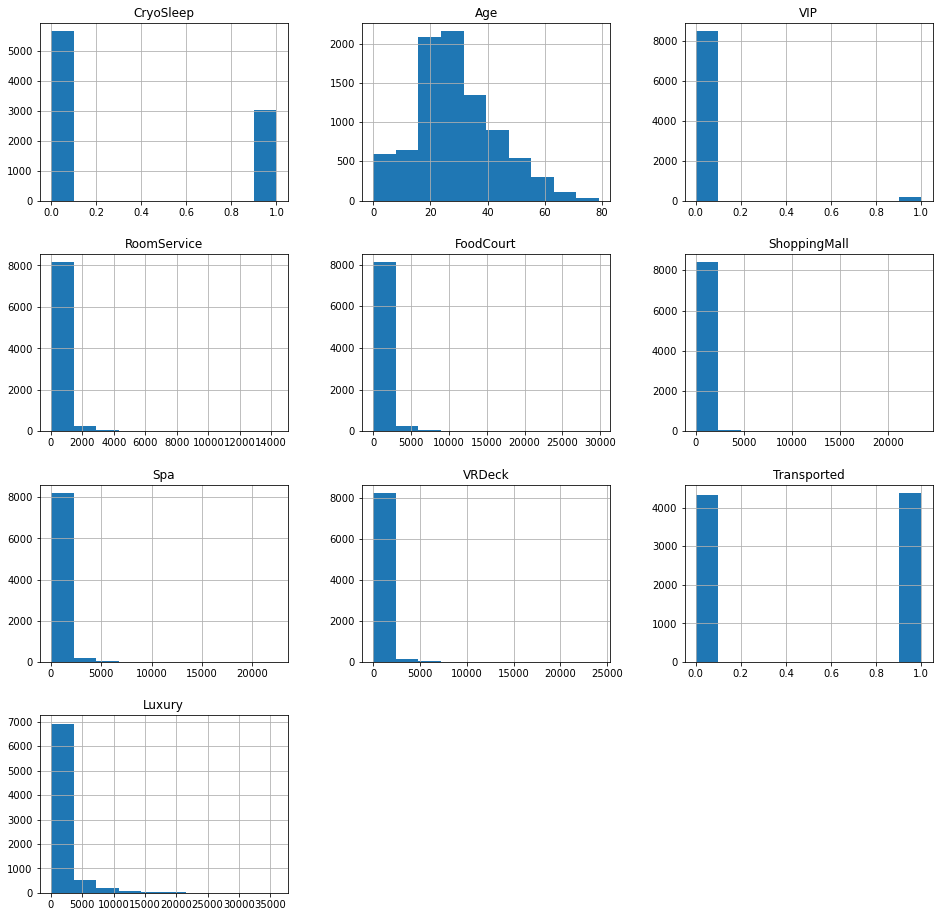

In [35]:
plt.rcParams["figure.figsize"] = (16, 16)
pd_data_vis.hist()

<AxesSubplot:>

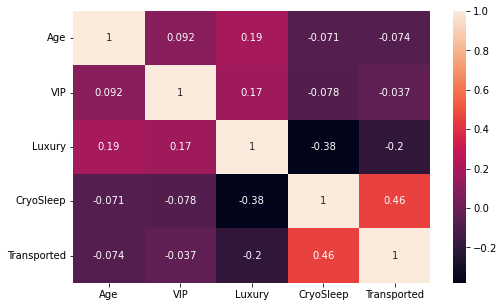

In [36]:
plt.figure(figsize=(8, 5))
corr_matrix = pd_data_vis[['Age', 'VIP', 'Luxury', 'CryoSleep', 'Transported']].corr()
sns.heatmap(corr_matrix, annot=True)

<AxesSubplot:xlabel='Transported', ylabel='Count'>

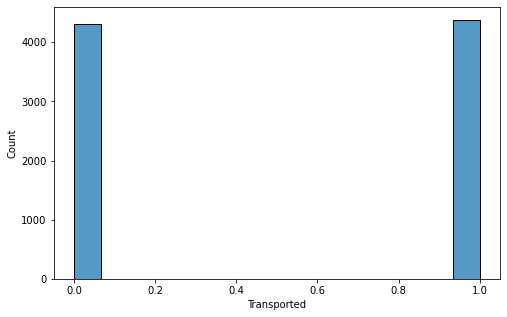

In [37]:
plt.figure(figsize=(8, 5))
sns.histplot(data=pd_data_vis, x=pd_data_vis['Transported'])

**Max correlation: transported -- CryoSleep**

**Dataset balansed by TARGET**

# Submission

In [38]:
def form_submission(path, pred, data_test):
    pred = pd.Series(pred[:,0],name='Transported')
    submission = pd.DataFrame(data=(data_test['PassengerId'],pred)).T
    
    submission['Transported'] = submission['Transported'].replace({1: True, 0: False})
    submission.to_csv(path, index=False)

# Split dataset to train and test

In [39]:
class Dataset:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.__X_train = X_train.to_numpy()
        self.__X_test = X_test.to_numpy()
        self.__y_train = y_train.to_numpy().astype('float32')
        self.__y_test = y_test.to_numpy().astype('float32')
    def get_dataset_train(self):
        return {
            'X_train': self.__X_train,
            'y_train': self.__y_train,
        }
    def get_dataset_test(self):
        return {
            'X_test': self.__X_test,
            'y_test': self.__y_test
        }

In [40]:
def split_dataset(dataset, target:str, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(dataset.loc[:, dataset.columns != target], 
                                                    dataset[target], test_size=test_size)
    

    return Dataset(X_train, X_test, y_train, y_test)

In [41]:
datasets = [split_dataset(set, 'Transported') for set in all_datasets]

# Metrics and scores

In [42]:
class Metrics:
    def __init__(self, real_target, pred_target, pred_proba_target):
        self.real_target = real_target
        self.pred_target = pred_target
        self.pred_proba_target = pred_proba_target
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.roc_auc = None
        if self.real_target.shape == self.pred_target.shape:
            self.initiate_scores()
        else:
            print('Shapes not equal!') 
           
    def initiate_scores(self):
        self.accuracy = accuracy_score(self.real_target, self.pred_target)
        self.precision = precision_score(self.real_target, self.pred_target)
        self.recall = recall_score(self.real_target, self.pred_target)
        self.f1 = f1_score(self.real_target, self.pred_target)
        self.roc_auc = roc_auc_score(self.real_target, self.pred_proba_target)
    
    def show_metrics(self):
        print(f'''        Accuracy: {self.accuracy:.4f}  
        Precision: {self.precision:.4f}  
        Recall: {self.recall:.4f} 
        F1: { self.f1:.4f}
        ROC_AUC: {self.roc_auc:.4f}''')
        
    def get_metrics(self):
        return {
            'Accuracy': self.accuracy,
            'Precision': self.precision,
            'Recall': self.recall,
            'F1': self.f1,
            'ROC_AUC': self.roc_auc
        }
    
    def plot_roc_auc(self):
        fpr, tpr, thrhold = roc_curve(self.real_target, self.pred_proba_target)
        auc_res = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='green')
        plt.plot((0, 1), linestyle='-')
        plt.title(f'AUC = {auc_res:.3f}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    def plot_conf_matrix(self):
        conf_matrix = confusion_matrix(self.real_target, self.pred_target)
        sns.heatmap(conf_matrix, annot=True, fmt='.0f')
        
    @staticmethod
    def analyst_theshold(real_target, pred_proba, *thresholds):
        if not thresholds:
            return
        all_metrics = {}
        best_metrics = {
            'Accuracy': {'Threshold': 0, 'Value': 0},
            'Precision': {'Threshold': 0, 'Value': 0},
            'Recall': {'Threshold': 0, 'Value': 0},
            'F1': {'Threshold': 0, 'Value': 0}
        }
        for threshold in thresholds:
            pred_target = np.array([1 if target > threshold else 0 for target in pred_proba])
            metrics = Metrics(real_target, pred_target).get_metrics()
            all_metrics[f'threshold {threshold}'] = metrics
            for metric in best_metrics.keys():
                if metrics[metric] > best_metrics[metric]['Value']:
                    best_metrics[metric]['Value'] = metrics[metric]
                    best_metrics[metric]['Threshold'] = threshold    
        return all_metrics, best_metrics
        

# Logistic Regression

In [43]:
#Train model
def train_test_lr_model(*datasets):
    result_models = {}
    pred_metrics = {}
    if datasets:
        for i, dataset in zip(range(len(datasets)), datasets):
            #Train
            data_train = dataset.get_dataset_train()
            model = LogisticRegression(max_iter=2000).fit(data_train['X_train'], data_train['y_train'])
            result_models[f'lr_model_{i}'] = model
            #Test
            data_test = dataset.get_dataset_test()
            pred_test = model.predict(data_test['X_test'])
            pred_test_proba = model.predict_proba(data_test['X_test'])[:,1]
            metrics = Metrics(data_test['y_test'], pred_test, pred_test_proba)
            pred_metrics[f'lr_model_{i}'] = {
                'prediction': pred_test,
                'prediction_proba': pred_test_proba,
                'metrics': metrics
            }
    return result_models, pred_metrics

In [44]:
lr_models, lr_metrics = train_test_lr_model(*datasets)

In [45]:
for model, metrics in lr_metrics.items():
    print(model)
    metrics['metrics'].show_metrics()

lr_model_0
        Accuracy: 0.7631  
        Precision: 0.8048  
        Recall: 0.6935 
        F1: 0.7450
        ROC_AUC: 0.8572
lr_model_1
        Accuracy: 0.7683  
        Precision: 0.7979  
        Recall: 0.7116 
        F1: 0.7523
        ROC_AUC: 0.8533
lr_model_2
        Accuracy: 0.7711  
        Precision: 0.8167  
        Recall: 0.7230 
        F1: 0.7670
        ROC_AUC: 0.8381
lr_model_3
        Accuracy: 0.7993  
        Precision: 0.7863  
        Recall: 0.8249 
        F1: 0.8051
        ROC_AUC: 0.8818
lr_model_4
        Accuracy: 0.7890  
        Precision: 0.7856  
        Recall: 0.8076 
        F1: 0.7965
        ROC_AUC: 0.8793


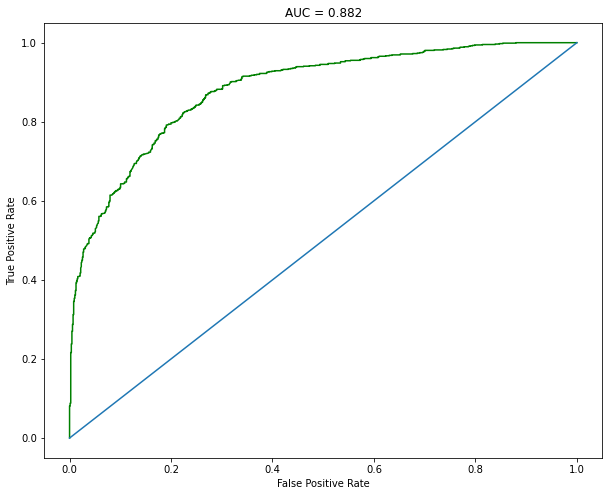

In [46]:
#plot best model - lr_model_3
plt.figure(figsize=(10,8))
best_model = lr_models['lr_model_3']
best_model_metr = lr_metrics['lr_model_3']['metrics']
best_model_metr.plot_roc_auc()

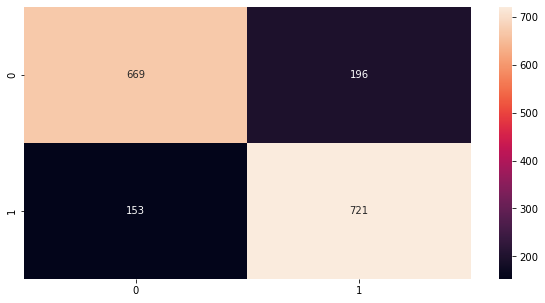

In [47]:
plt.figure(figsize=(10,5))
best_model_metr.plot_conf_matrix()

In [48]:
#Submission_best_lr
test_set = pd_test.copy()
data_pipe_test_set_4 = Pipeline(data_pipeline_set_4)
data_pipe_test_set_4.transform(test_set)

FeatureOneHotEncoder initiate
Encoded feature
FeatureOneHotEncoder initiate
Encoded feature
Cabin feature is divided
FeaturesSum initiate
Sum feature
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Encoded feature
Encoded feature
Changed feature
Changed feature
Dropped features


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,A,B,...,Group_pass,High_luxury,Low_luxury,Mid_luxury,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1,0,1,0,0,0,0,1
1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,0,0,...,0,0,1,0,1,0,0,0,0,1
2,1,31.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1,0,0,1,0,1,0,0
3,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,0,0,...,0,0,0,1,0,1,0,0,0,1
4,0,20.0,0,10.0,0.0,635.0,0.0,0.0,0,0,...,0,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,34.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,1,0,1,0,1,0,0,0,0,1
4273,0,42.0,0,0.0,847.0,17.0,10.0,144.0,0,0,...,0,0,1,0,1,0,0,0,0,1
4274,1,29.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1,0,0,0,1,1,0,0
4275,0,29.0,0,0.0,2680.0,0.0,0.0,523.0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [49]:
sub_pred = best_model.predict(test_set).reshape(-1,1)
form_submission('/kaggle/working/sub_log_reg_2.csv',sub_pred, pd_test)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


**Submission result - 0.77601**

# RandomForest

In [50]:
parameters = {
    'n_estimators': [100, 200, 400, 500, 1000, 1200],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [2, 5]
}

In [51]:
#Train model
def train_test_rfcv_model(parameters:dict, *datasets):
    result_models = {}
    pred_metrics = {}
    if datasets:
        for i, dataset in zip(range(len(datasets)), datasets):
            #Train
            data_train = dataset.get_dataset_train()
            print(f'Start dataset {i+1}')
            model = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, 
                                 verbose=2).fit(data_train['X_train'], data_train['y_train'])
            result_models[f'rf_model_{i}'] = model
            print(f'End dataset {i+1}')
            #Test
            data_test = dataset.get_dataset_test()
            pred_test = model.predict(data_test['X_test'])
            pred_test_proba = model.predict_proba(data_test['X_test'])[:,1]
            metrics = Metrics(data_test['y_test'], pred_test, pred_test_proba)
            pred_metrics[f'rf_model_{i}'] = {
                'prediction': pred_test,
                'prediction_proba': pred_test_proba,
                'metrics': metrics
            }
    return result_models, pred_metrics

In [52]:
rf_models, rf_metrics = train_test_rfcv_model(parameters, *datasets)

Start dataset 1
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=200; total time=   0.7s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=200; total time=   0.7s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=200; total time=   0.7s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=200; total time=   0.7s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=200; total time=   0.7s
[CV] END ..max_depth=5, min_samples_leaf=2, n_estimators=400; total time=   1.4s
[CV] END ..max_depth=5, min_sam

In [53]:
for name_model, model in rf_models.items():
    print(name_model)
    print(model.best_params_)

rf_model_0
{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
rf_model_1
{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 500}
rf_model_2
{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 500}
rf_model_3
{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 1200}
rf_model_4
{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200}


In [54]:
for model, metrics in rf_metrics.items():
    print(model)
    metrics['metrics'].show_metrics()

rf_model_0
        Accuracy: 0.7895  
        Precision: 0.7833  
        Recall: 0.7995 
        F1: 0.7913
        ROC_AUC: 0.8845
rf_model_1
        Accuracy: 0.8033  
        Precision: 0.7917  
        Recall: 0.8174 
        F1: 0.8043
        ROC_AUC: 0.8877
rf_model_2
        Accuracy: 0.8005  
        Precision: 0.8216  
        Recall: 0.7881 
        F1: 0.8045
        ROC_AUC: 0.8741
rf_model_3
        Accuracy: 0.8108  
        Precision: 0.8165  
        Recall: 0.8043 
        F1: 0.8104
        ROC_AUC: 0.8875
rf_model_4
        Accuracy: 0.7976  
        Precision: 0.8097  
        Recall: 0.7897 
        F1: 0.7995
        ROC_AUC: 0.8841


**best model - model_2,3**

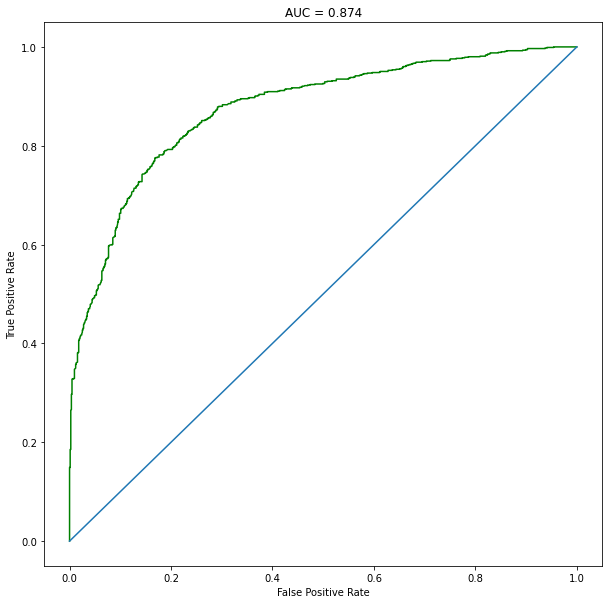

In [55]:
#plot best model - model_2
plt.figure(figsize=(10,10))
best_model = rf_models['rf_model_2']
best_model_metr = rf_metrics['rf_model_2']['metrics']
best_model_metr.plot_roc_auc()

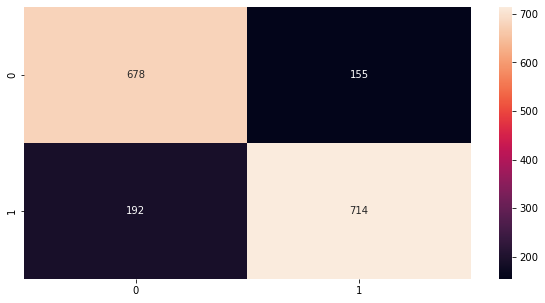

In [56]:
plt.figure(figsize=(10,5))
best_model_metr.plot_conf_matrix()

In [57]:
#Submission_best_rf
test_set = pd_test.copy()
data_pipe_test_set_3 = Pipeline(data_pipeline_set_3)
data_pipe_test_set_3.transform(test_set)

FeatureOneHotEncoder initiate
Encoded feature
FeatureOneHotEncoder initiate
Encoded feature
Cabin feature is divided
FeaturesSum initiate
Sum feature
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Encoded feature
Encoded feature
Changed feature
Changed feature
Dropped features
0
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,A,B,...,TRAPPIST-1e,Age_gr_1,Age_gr_2,Age_gr_3,Age_gr_4,Age_gr_5,Age_gr_6,Age_gr_7,Age_gr_8,Age_gr_9
0,1,0.341772,0,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0.240506,0,0.000000,0.000356,0.00000,0.142260,0.000000,0,0,...,1,0,0,0,0,1,0,0,0,0
2,1,0.392405,0,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0.481013,0,0.000000,0.263206,0.00000,0.009121,0.026266,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,0.253165,0,0.000865,0.000000,0.07658,0.000000,0.000000,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,0.430380,0,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,...,1,0,0,0,0,0,0,1,0,0
4273,0,0.531646,0,0.000000,0.033514,0.00205,0.000504,0.006466,0,0,...,1,0,0,0,0,0,0,1,0,0
4274,1,0.367089,0,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
4275,0,0.367089,0,0.000000,0.106042,0.00000,0.000000,0.023482,0,0,...,1,0,0,0,0,0,1,0,0,0


In [58]:
sub_pred = rf_models['rf_model_2'].predict(test_set).reshape(-1,1)
form_submission('/kaggle/working/sub_randforest_3.csv',sub_pred, pd_test)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [59]:
test_set_2 = pd_test.copy()
data_pipe_test_set_2 = Pipeline(data_pipeline_set_2)
data_pipe_test_set_2.transform(test_set_2)

FeatureLabelEncoder initiate
FeatureLabelEncoder initiate
Cabin feature is divided
FeaturesSum initiate
Sum feature
FeatureLabelEncoder initiate
FeatureDropper initiate
Dropped features
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Changed feature
Changed feature
Dropped features


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_d,Cabin_s,Group_pass,Luxury_group
0,0.000000,1,0.666667,0.341772,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.857143,1.0,0,0.5
1,0.000000,0,0.666667,0.240506,0,0.000000,0.000356,0.00000,0.142260,0.000000,0.714286,1.0,0,0.5
2,0.333333,1,0.000000,0.392405,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.285714,1.0,0,0.5
3,0.333333,0,0.666667,0.481013,0,0.000000,0.263206,0.00000,0.009121,0.026266,0.285714,1.0,0,1.0
4,0.000000,0,0.666667,0.253165,0,0.000865,0.000000,0.07658,0.000000,0.000000,0.714286,1.0,0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.000000,1,0.666667,0.430380,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.857143,1.0,1,0.5
4273,0.000000,0,0.666667,0.531646,0,0.000000,0.033514,0.00205,0.000504,0.006466,0.714286,1.0,0,0.5
4274,0.666667,1,0.000000,0.367089,0,0.000000,0.000000,0.00000,0.000000,0.000000,0.428571,0.0,0,0.5
4275,0.333333,0,1.000000,0.367089,0,0.000000,0.106042,0.00000,0.000000,0.023482,0.428571,0.0,0,0.5


**Submission result 0.79401**

# GradientBoostingClassifier

In [60]:
#Train model
def train_test_gbc_model(*datasets):
    result_models = {}
    pred_metrics = {}
    if datasets:
        for i, dataset in zip(range(len(datasets)), datasets):
            #Train
            data_train = dataset.get_dataset_train()
            model = GradientBoostingClassifier(n_estimators=500).fit(data_train['X_train'], data_train['y_train'])
            result_models[f'gb_model_{i}'] = model
            #Test
            data_test = dataset.get_dataset_test()
            pred_test = model.predict(data_test['X_test'])
            pred_test_proba = model.predict_proba(data_test['X_test'])[:,1]
            metrics = Metrics(data_test['y_test'], pred_test, pred_test_proba)
            pred_metrics[f'gb_model_{i}'] = {
                'prediction': pred_test,
                'prediction_proba': pred_test_proba,
                'metrics': metrics
            }
    return result_models, pred_metrics

In [61]:
gb_models, gb_metrics = train_test_gbc_model(*datasets)

In [62]:
for model, metrics in gb_metrics.items():
    print(model)
    metrics['metrics'].show_metrics()

gb_model_0
        Accuracy: 0.7872  
        Precision: 0.7779  
        Recall: 0.8030 
        F1: 0.7902
        ROC_AUC: 0.8800
gb_model_1
        Accuracy: 0.7953  
        Precision: 0.7794  
        Recall: 0.8174 
        F1: 0.7980
        ROC_AUC: 0.8865
gb_model_2
        Accuracy: 0.7872  
        Precision: 0.7939  
        Recall: 0.7991 
        F1: 0.7965
        ROC_AUC: 0.8779
gb_model_3
        Accuracy: 0.8097  
        Precision: 0.8013  
        Recall: 0.8261 
        F1: 0.8135
        ROC_AUC: 0.8904
gb_model_4
        Accuracy: 0.7918  
        Precision: 0.7905  
        Recall: 0.8065 
        F1: 0.7984
        ROC_AUC: 0.8833


*Best model is Model trained on set_3, set_4*

In [63]:
#Submission_best_gb
test_set = pd_test.copy()
data_pipe_test_set_3 = Pipeline(data_pipeline_set_3)
data_pipe_test_set_3.transform(test_set)

FeatureOneHotEncoder initiate
Encoded feature
FeatureOneHotEncoder initiate
Encoded feature
Cabin feature is divided
FeaturesSum initiate
Sum feature
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Encoded feature
Encoded feature
Changed feature
Changed feature
Dropped features
0
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,A,B,...,TRAPPIST-1e,Age_gr_1,Age_gr_2,Age_gr_3,Age_gr_4,Age_gr_5,Age_gr_6,Age_gr_7,Age_gr_8,Age_gr_9
0,1,0.341772,0,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,...,1,0,0,0,0,0,1,0,0,0
1,0,0.240506,0,0.000000,0.000356,0.00000,0.142260,0.000000,0,0,...,1,0,0,0,0,1,0,0,0,0
2,1,0.392405,0,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0.481013,0,0.000000,0.263206,0.00000,0.009121,0.026266,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,0.253165,0,0.000865,0.000000,0.07658,0.000000,0.000000,0,0,...,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,0.430380,0,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,...,1,0,0,0,0,0,0,1,0,0
4273,0,0.531646,0,0.000000,0.033514,0.00205,0.000504,0.006466,0,0,...,1,0,0,0,0,0,0,1,0,0
4274,1,0.367089,0,0.000000,0.000000,0.00000,0.000000,0.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
4275,0,0.367089,0,0.000000,0.106042,0.00000,0.000000,0.023482,0,0,...,1,0,0,0,0,0,1,0,0,0


In [64]:
sub_pred = gb_models['gb_model_2'].predict(test_set).reshape(-1,1)
form_submission('/kaggle/working/sub_grad_boost_4.csv',sub_pred, pd_test)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


* Submission model_3 result 0.80173
* Submission model_2 result 0.79003

# Neutral network

In [65]:
pip install torch-summary

Note: you may need to restart the kernel to use updated packages.


In [66]:
from torchsummary import summary

In [67]:
class Neural(nn.Module):
    def __init__(self, n_features, bn=False, dp=True, bias=True):
        super().__init__()
        self.n_features = n_features
        self.bn = bn
        self.dp = dp
        self.bias = bias
        
        self.linear_1 = self.form_layer(self.n_features, 256)
        self.linear_2 = self.form_layer(256, 512)
        self.linear_3 = self.form_layer(512, 256)
        self.linear_4 = nn.Linear(256, 1)
        
    def form_layer(self, in_n, out_n):
        layer_list = [nn.Linear(in_n, out_n, bias=self.bias)]
        if self.bn:
            layer_list.append(nn.BatchNorm1d(out_n))
        layer_list.append(nn.LeakyReLU(0.1))
        if self.dp: 
                layer_list.append(nn.Dropout(0.5)) 
        return nn.Sequential(*layer_list)
        
    def forward(self, x):
        x = self.linear_1(x)
        x = self.linear_2(x)
        x = self.linear_3(x)
        x = self.linear_4(x)
        
        return nn.Sigmoid()(x)

In [68]:
n = Neural(5, bn=True)
summary(n, (5,))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─Linear: 2-1                       [-1, 256]                 1,536
|    └─BatchNorm1d: 2-2                  [-1, 256]                 512
|    └─LeakyReLU: 2-3                    [-1, 256]                 --
|    └─Dropout: 2-4                      [-1, 256]                 --
├─Sequential: 1-2                        [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 512]                 131,584
|    └─BatchNorm1d: 2-6                  [-1, 512]                 1,024
|    └─LeakyReLU: 2-7                    [-1, 512]                 --
|    └─Dropout: 2-8                      [-1, 512]                 --
├─Sequential: 1-3                        [-1, 256]                 --
|    └─Linear: 2-9                       [-1, 256]                 131,328
|    └─BatchNorm1d: 2-10                 [-1, 256]                 5

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─Linear: 2-1                       [-1, 256]                 1,536
|    └─BatchNorm1d: 2-2                  [-1, 256]                 512
|    └─LeakyReLU: 2-3                    [-1, 256]                 --
|    └─Dropout: 2-4                      [-1, 256]                 --
├─Sequential: 1-2                        [-1, 512]                 --
|    └─Linear: 2-5                       [-1, 512]                 131,584
|    └─BatchNorm1d: 2-6                  [-1, 512]                 1,024
|    └─LeakyReLU: 2-7                    [-1, 512]                 --
|    └─Dropout: 2-8                      [-1, 512]                 --
├─Sequential: 1-3                        [-1, 256]                 --
|    └─Linear: 2-9                       [-1, 256]                 131,328
|    └─BatchNorm1d: 2-10                 [-1, 256]                 5

In [69]:
def create_dataloader(bs, *datasets):
    dataloaders = {}
    if datasets:
        for i, dataset in zip(range(len(datasets)), datasets):
            data_train = dataset.get_dataset_train()
            data_test = dataset.get_dataset_test()
            data_train = [(x, y) for x, y in zip(data_train['X_train'], data_train['y_train'])]
            data_test = [(x, y) for x, y in zip(data_test['X_test'], data_test['y_test'])] 
            dataloaders[f'dataloader_{i}'] = {
                f'dataloader_train': DataLoader(data_train, bs),
                f'dataloader_test': DataLoader(data_test, bs),
            }
    return dataloaders

In [70]:
data_loaders = create_dataloader(16, *datasets)

In [71]:
def train(model, data_train, data_test, loss, opt, epochs=40):
    history = {
        'loss_train': [],
        'score_train': [],
        'loss_test': [],
        'score_test': []
    }
    for epoch in range(epochs):
        model.train()
        i=0
        ep_loss = []
        ep_score = []
        ep_test_loss = []
        ep_test_score = []
        print(f'Epoch {epoch+1}')
        for x, y in data_train:
            x = x.type(torch.float32)
            y = y.view(-1,1)
            opt.zero_grad()
            predict = model(x)
            score = torch.tensor([(p == t).type(torch.int) for p,t in zip (torch.round(predict), y)])
            _loss = loss(predict, y)
            ep_loss.append(_loss)
            ep_score.append(score)
            _loss.backward()
            opt.step()
        ep_score = torch.cat(ep_score).detach().numpy()
        ep_loss = torch.stack(ep_loss).detach().numpy()
        print(f'Loss: {np.sum(ep_loss)/ep_loss.shape[0]} \
              Score: {np.sum(ep_score)/ep_score.shape[0]}')
        history['loss_train'].append(sum(ep_loss)/len(ep_loss))
        history['score_train'].append(sum(ep_score)/len(ep_score))
        with torch.no_grad():
            model.eval()
            for x, y in data_test:
                x = x.type(torch.float32)
                y = y.view(-1,1)
                test_pred = model(x)
                test_loss = loss(test_pred, y)
                score = torch.tensor([(p == t).type(torch.int) for p,t in zip (torch.round(test_pred), y)])
                ep_test_loss.append(test_loss)
                ep_test_score.append(score)
            ep_test_score = torch.cat(ep_test_score).detach().numpy()
            ep_test_loss = torch.stack(ep_test_loss).detach().numpy()
            print(f'Test Loss: {np.sum(ep_test_loss)/ep_test_loss.shape[0]} \
                  Score: {np.sum(ep_test_score)/ep_test_score.shape[0]}')
            history['loss_test'].append(sum(ep_test_loss)/len(ep_test_loss))
            history['score_test'].append(sum(ep_test_score)/len(ep_test_score))
    return history

In [72]:
def train_nn_model(loss, model, epochs, **loaders):
    models_nn = {}
    if loaders:
        i = 0
        for nameloader, loader in loaders.items():
            i += 1
            n_features = loader['dataloader_train'].dataset[0][0].shape[0]   
            model_nn = model(n_features)
            optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.0002)
            history = train(model_nn, loader['dataloader_train'], loader['dataloader_test'], loss, optimizer, epochs)
            models_nn[f'model_{i}'] = {
                'model': model_nn,
                'history': history
            }
    return models_nn

In [73]:
loss = nn.BCELoss()
models_nn = train_nn_model(loss, Neural, 60, **data_loaders)

Epoch 1
Loss: 0.599182269216954               Score: 0.677739430543572
Test Loss: 0.5261873367729537                   Score: 0.7268545140885566
Epoch 2
Loss: 0.5357319097409303               Score: 0.726200747771067
Test Loss: 0.5105347939587515                   Score: 0.7337550316273721
Epoch 3
Loss: 0.5240237882767601               Score: 0.7313776243888409
Test Loss: 0.5007778832671839                   Score: 0.7429557216791259
Epoch 4
Loss: 0.5155269929732399               Score: 0.7354040839804429
Test Loss: 0.4906187144988174                   Score: 0.753306497987349
Epoch 5
Loss: 0.5018961588541667               Score: 0.7492090882945067
Test Loss: 0.48060740899602206                   Score: 0.7550316273720529
Epoch 6
Loss: 0.4962615616020115               Score: 0.7506471095772217
Test Loss: 0.4742613626182626                   Score: 0.7573317998849913
Epoch 7
Loss: 0.48430905396910917               Score: 0.7540983606557377
Test Loss: 0.4656692994843929                  

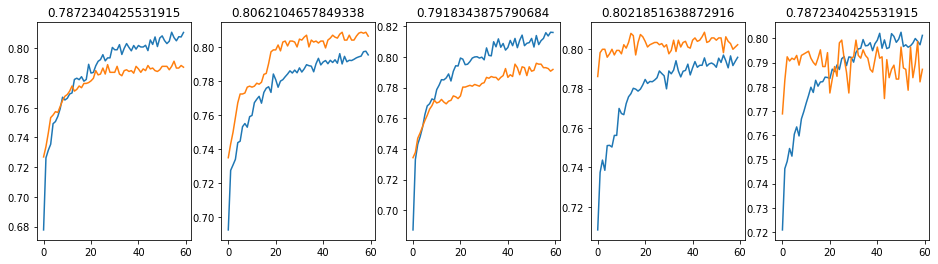

In [74]:
plt.figure(figsize=(16,4))
plt.subplot(1,5,1)
plt.title(models_nn['model_1']['history']['score_test'][-1])
plt.plot(models_nn['model_1']['history']['score_train'])
plt.plot(models_nn['model_1']['history']['score_test'])
plt.subplot(1,5,2)
plt.title(models_nn['model_2']['history']['score_test'][-1])
plt.plot(models_nn['model_2']['history']['score_train'])
plt.plot(models_nn['model_2']['history']['score_test'])
plt.subplot(1,5,3)
plt.title(models_nn['model_3']['history']['score_test'][-1])
plt.plot(models_nn['model_3']['history']['score_train'])
plt.plot(models_nn['model_3']['history']['score_test'])
plt.subplot(1,5,4)
plt.title(models_nn['model_4']['history']['score_test'][-1])
plt.plot(models_nn['model_4']['history']['score_train'])
plt.plot(models_nn['model_4']['history']['score_test'])
plt.subplot(1,5,5)
plt.title(models_nn['model_5']['history']['score_test'][-1])
plt.plot(models_nn['model_5']['history']['score_train'])
plt.plot(models_nn['model_5']['history']['score_test'])

Model trained on set_3 is best, trying submission

In [75]:
test_set = pd_test.copy()
data_pipe_test_set_3 = Pipeline(data_pipeline_set_3)
data_pipe_test_set_3.transform(test_set)
test_set = test_set.to_numpy()

FeatureOneHotEncoder initiate
Encoded feature
FeatureOneHotEncoder initiate
Encoded feature
Cabin feature is divided
FeaturesSum initiate
Sum feature
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Encoded feature
Encoded feature
Changed feature
Changed feature
Dropped features
0
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features


In [76]:
sub_pred = models_nn['model_3']['model'](torch.Tensor(test_set)).reshape(-1,1).detach().numpy()
sub_pred = np.array([pred.round() for pred in sub_pred])
form_submission('/kaggle/working/sub_nn_2.csv',sub_pred, pd_test)

In [77]:
test_set_2 = pd_test.copy()
data_pipe_test_set_4 = Pipeline(data_pipeline_set_4)
data_pipe_test_set_4.transform(test_set_2)
test_set_2 = test_set_2.to_numpy()
sub_pred = models_nn['model_4']['model'](torch.Tensor(test_set_2)).reshape(-1,1).detach().numpy()
sub_pred = np.array([pred.round() for pred in sub_pred])
form_submission('/kaggle/working/sub_nn_3.csv',sub_pred, pd_test)

FeatureOneHotEncoder initiate
Encoded feature
FeatureOneHotEncoder initiate
Encoded feature
Cabin feature is divided
FeaturesSum initiate
Sum feature
FeatureOneHotEncoder initiate
Encoded feature
FeatureDropper initiate
Dropped features
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Encoded feature
Encoded feature
Changed feature
Changed feature
Dropped features


In [78]:
test_set_2 = pd_test.copy()
data_pipe_test_set_2 = Pipeline(data_pipeline_set_2)
data_pipe_test_set_2.transform(test_set_2)
test_set_2 = test_set_2.to_numpy()
sub_pred = models_nn['model_2']['model'](torch.Tensor(test_set_2)).reshape(-1,1).detach().numpy()
sub_pred = np.array([pred.round() for pred in sub_pred])
form_submission('/kaggle/working/sub_nn_2.csv',sub_pred, pd_test)

FeatureLabelEncoder initiate
FeatureLabelEncoder initiate
Cabin feature is divided
FeaturesSum initiate
Sum feature
FeatureLabelEncoder initiate
FeatureDropper initiate
Dropped features
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Imputed feature
Changed feature
Changed feature
Dropped features


The best NN result is 0.79191

**Random Forest, Gradboost and N_Network have similar results**

**Best result is 0.8017 Gradboost**